In [58]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20
dataset=tf.keras.preprocessing.image_dataset_from_directory("Training/Leaf_photos",shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 4072 files belonging to 3 classes.


In [5]:
dataset.class_names

['EarlyBlight', 'Healthy', 'LateBlight']

In [6]:
len(dataset) #every dataset in the directory is a batch of 32

128

In [7]:
32*128

4096

In [8]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 2 1 1 1 0 2 1 0 0 1 1 2 0 0 2 1 1 2 0 0 2 0 1 0 1 0 0 1 0 2]


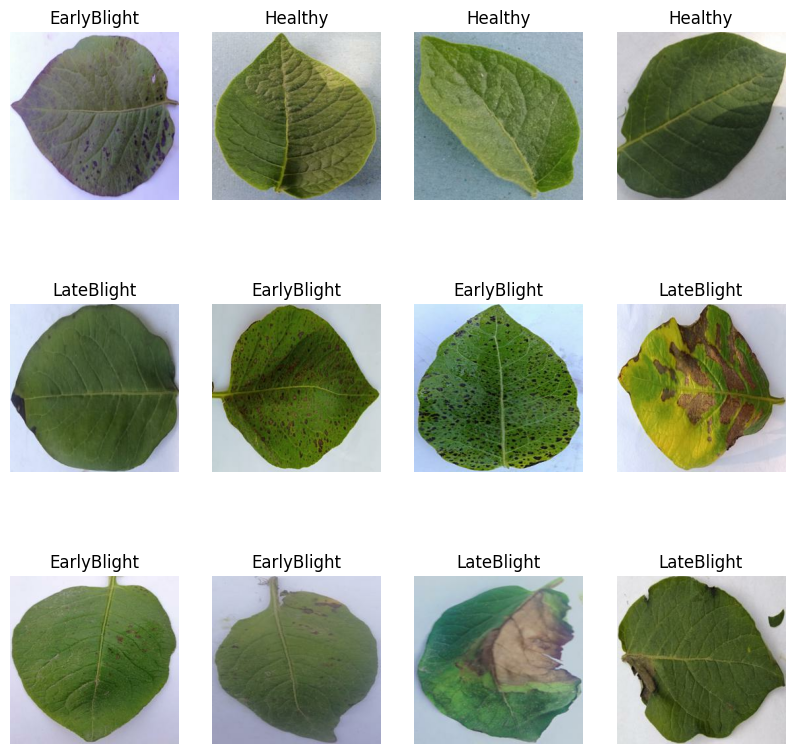

In [66]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
for i in dataset.take(1):
    print(i[0].numpy().shape)

(32, 256, 256, 3)


In [12]:
len(dataset)

128

In [13]:
train_size=0.8
len(dataset)*train_size

102.4

In [14]:
train_ds=dataset.take(102)

In [15]:
len(train_ds)

102

In [16]:
test_ds=dataset.skip(102)

In [17]:
len(test_ds)

26

In [18]:
validation_size=0.1
round(len(test_ds)*validation_size)

3

In [19]:
validation_dataset=test_ds.take(3)
test_dataset=test_ds.skip(3)

In [20]:
len(test_dataset)

23

In [21]:
def get_data_partition(df,train_split=0.8,validation_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):

    df_size=len(df)
    if shuffle:
        ds=df.shuffle(shuffle_size,seed=12)
    train_ds=df.take(round(((df_size))*train_split))
    validation_ds=df.take(round((df_size)*validation_split))
    test_ds=df.take(round((df_size)*test_split))

    return (train_ds),(test_ds),(validation_ds)

In [22]:
get_data_partition(df=dataset)

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [23]:
train_ds,test_ds,validation_ds=get_data_partition(df=dataset)

In [24]:
len(train_ds)

102

In [25]:
len(test_ds)

13

In [26]:
len(validation_ds)

13

In [27]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds=validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
resize_and_rescale=tf.keras.Sequential([
    keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.Rescaling(1.0/255),
])

In [29]:
data_augmenatation=tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal and vertical"),
    keras.layers.RandomRotation(0.2)
])

In [30]:
input_shapes=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=keras.models.Sequential([
    resize_and_rescale,
    data_augmenatation,
    keras.layers.Conv2D(filters=15,kernel_size=(3,3),activation="relu",input_shape=input_shapes),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(filters=30,kernel_size=(3,3),activation="relu"),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(filters=30,kernel_size=(3,3),activation="relu"),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dense(3,activation="softmax"),
])

model.build(input_shape=input_shapes)

e:\Preparation_2024\Syallabus\DL\Deep learning project end to end  Potato Disease Classification\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 15)     │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 30)     │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 27000)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │     1,728,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,740,889 (6.64 MB)

 Trainable params: 1,740,889 (6.64 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])

In [35]:
history=model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=validation_ds)

Epoch 1/20


e:\Preparation_2024\Syallabus\DL\Deep learning project end to end  Potato Disease Classification\venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


102/102 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.4054 - loss: 1.2419 - val_accuracy: 0.6034 - val_loss: 0.9332
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.6449 - loss: 0.8001 - val_accuracy: 0.7284 - val_loss: 0.7172
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 90s 880ms/step - accuracy: 0.7270 - loss: 0.6642 - val_accuracy: 0.7716 - val_loss: 0.5659
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 89s 868ms/step - accuracy: 0.7790 - loss: 0.5604 - val_accuracy: 0.7885 - val_loss: 0.5772
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 92s 899ms/step - accuracy: 0.8240 - loss: 0.4868 - val_accuracy: 0.8221 - val_loss: 0.4546
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 92s 900ms/step - accuracy: 0.8646 - loss: 0.3622 - val_accuracy: 0.7812 - val_loss: 0.7324
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 89s 868ms/step - accuracy: 0.8709 - loss: 0.3655 - val_accuracy: 0.8582 - val_loss: 0.3612
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 88s 865ms/step - accuracy: 0.8898 - loss: 0.2952 - val_acc

In [37]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [38]:
model_acc=history.history["accuracy"]
val_ac=history.history["val_accuracy"]
model_loss=history.history["loss"]
val_loss=history.history["val_loss"]

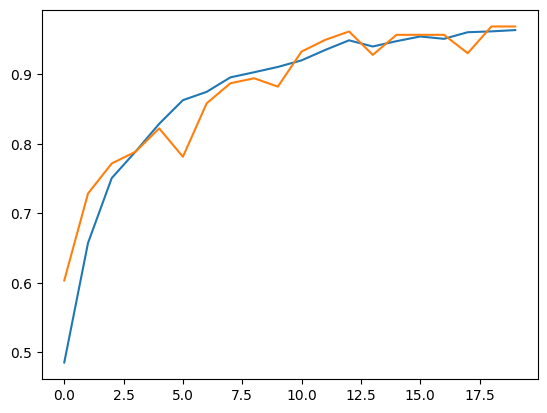

In [40]:
plt.plot(range(EPOCHS),model_acc)
plt.plot(range(EPOCHS),val_ac)

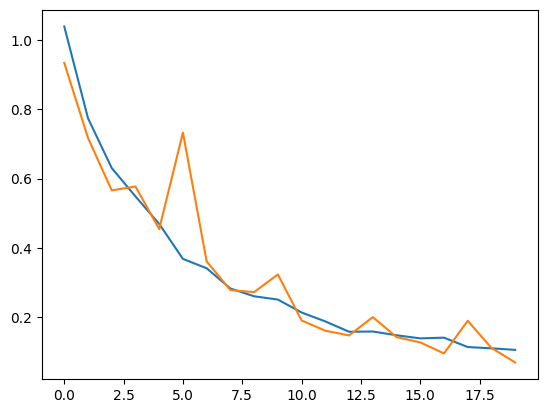

In [41]:
plt.plot(range(EPOCHS),model_loss)
plt.plot(range(EPOCHS),val_loss)

First image to predict
First image acutal label:- EarlyBlight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Predicted_label:- EarlyBlight


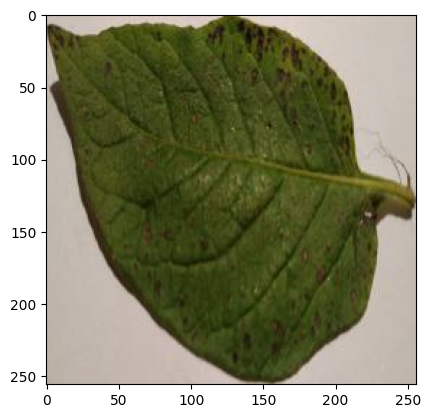

In [62]:
for image_batch,label in dataset.take(1):
    first_image=(image_batch[0].numpy().astype("uint8"))
    first_label=(label[0])

    print("First image to predict")
    plt.imshow(first_image)
    print("First image acutal label:-",dataset.class_names[first_label.numpy()])

    batch_predicttion=model.predict(image_batch) #prediction for whole 32 images(batch)
    print("Predicted_label:-",dataset.class_names[np.argmax(batch_predicttion[0])])

In [63]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = dataset.class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


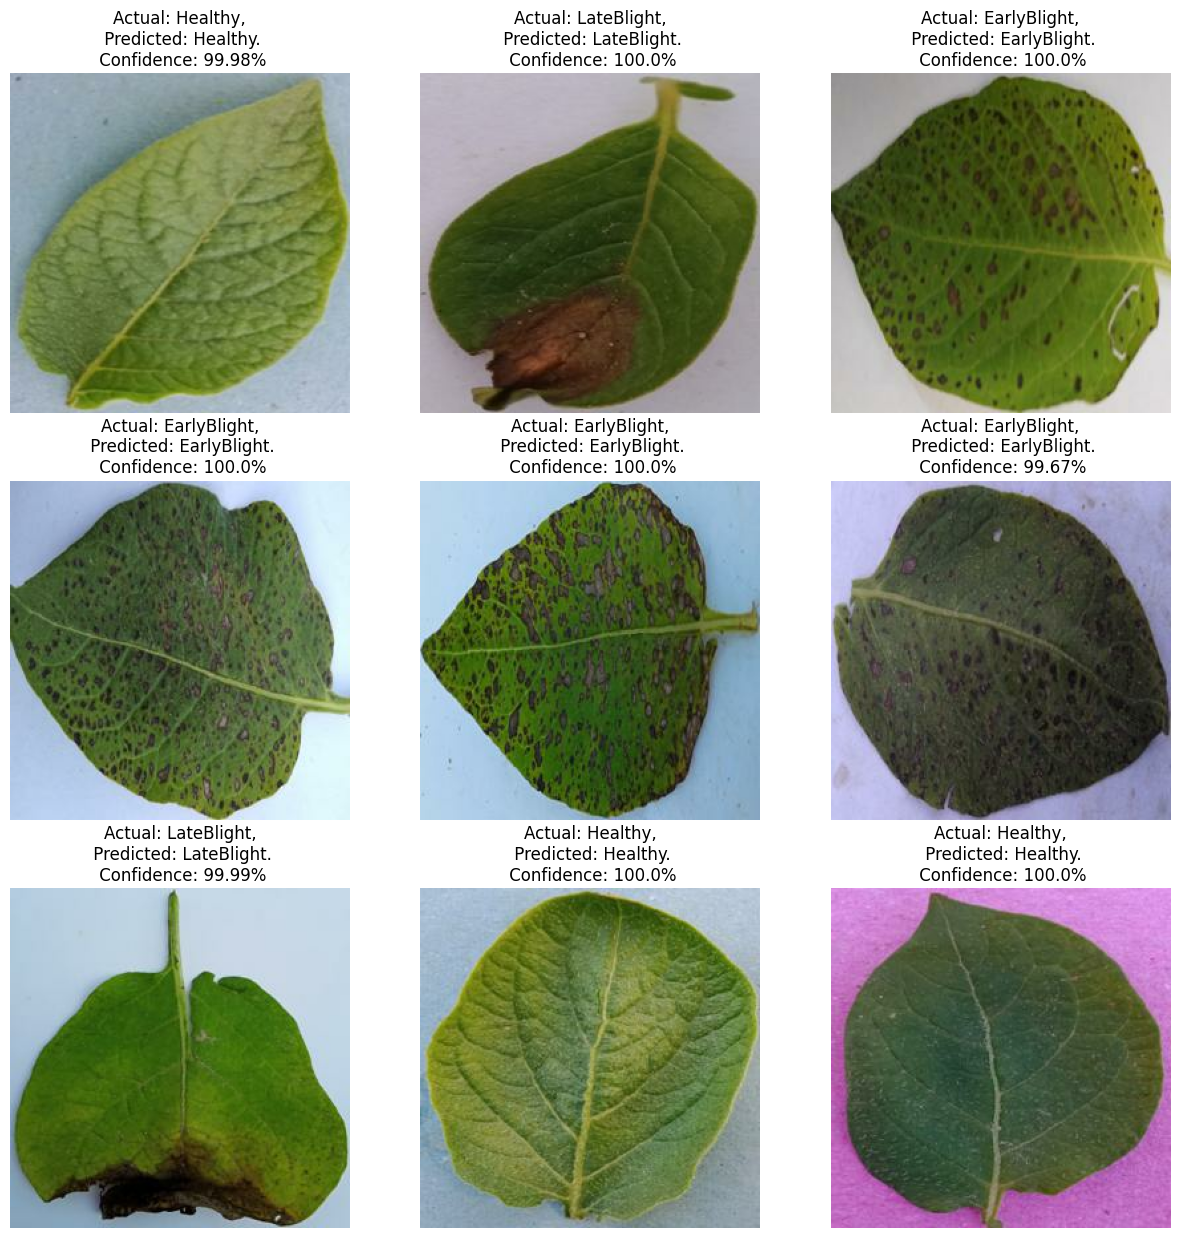

In [64]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = dataset.class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [82]:
model_version=1
model.save("models/model.keras")

In [69]:
import os

In [70]:
os.getcwd()

'e:\\Preparation_2024\\Syallabus\\DL\\Deep learning project end to end  Potato Disease Classification'